In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ppr.path import cart_to_joint, cart_to_joint_parallel, discretise
from ppr.ga import get_shortest_path_ga
import time
from multiprocessing import Pool

# Case 1

In [13]:
from planning_cases import robot1, path1, scene1

In [14]:
start = time.time()
path_js1 = cart_to_joint(robot1, path1, check_collision=True, scene=scene1)
end = time.time()
print("Standard function took {:.2f}s".format(end - start))

Standard function took 0.56s


In [15]:
def check_pose(pose):
    res = []
    sol = robot1.ik(pose)
    for qsol in sol['q']:
        if not robot1.check_collision(qsol, scene1):
            res.append(qsol)
    return res

def check_traj_pt(poses):
    res = []
    for pi in poses:
        res.append(check_pose(pi))
    return res

start = time.time()
tps = [discretise(tp) for tp in path1]
with Pool(processes=4) as pool:
    result = pool.map(check_traj_pt, tps)
end = time.time()
print("Parallel took {:.2f}s".format(end - start))

Parallel took 0.32s


In [12]:
sol1 = get_shortest_path_ga(path_js1, T_run=1)
print(sol1['success'])

True 1.0010907649993896


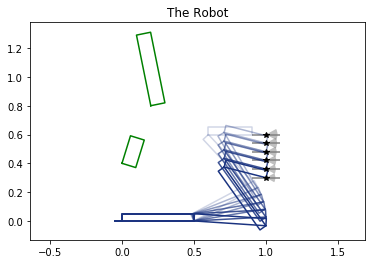

In [13]:
fig1, ax1 = plt.subplots()
plt.title("The Robot")
ax1.axis('equal')
robot1.plot_path(ax1, sol1['path'])
for tp in path1: tp.plot(ax1)
for r in scene1: r.plot(ax1, 'g')
plt.show()

# Case 2

In [2]:
from planning_cases import robot2, path2, scene2

In [5]:
robot2.ik_samples = [10, 10]
N_trajectory = path2[0].p[0].s * path2[0].p[2].s * len(path2)
print(N_trajectory)

print(N_trajectory * robot2.ik_samples[0] * robot2.ik_samples[1] * 8)

1200
960000


In [17]:
start = time.time()
path_js2 = cart_to_joint(robot2, path2, check_collision=True, scene=scene2)
end = time.time()
print("Standard function took {:.2f}s".format(end - start))

Standard function took 95.39s


In [25]:
def check_pose(pose):
    res = []
    sol = robot2.ik(pose)
    if sol['success']:
        for qsol in sol['q']:
            if not robot2.check_collision(qsol, scene2):
                res.append(qsol)
    return res

def check_traj_pt(poses):
    res = []
    for pi in poses:
        res.append(np.array(check_pose(pi)))
    return res

start = time.time()
tps = [discretise(tp) for tp in path2]
with Pool() as pool:
    result = pool.map(check_traj_pt, tps)
end = time.time()
print("Parallel took {:.2f}s".format(end - start))

Parallel took 29.78s


In [21]:
sol2 = get_shortest_path_ga(path_js2, T_run=5)
print(sol2['success'])

ValueError: operands could not be broadcast together with shapes (0,) (61,5) 

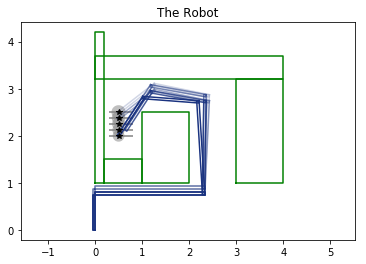

In [67]:
fig2, ax2 = plt.subplots()
plt.title("The Robot")
ax2.axis('equal')
robot2.plot_path(ax2, sol2['path'])
for tp in path2: tp.plot(ax2)
for r in scene2: r.plot(ax2, 'g')
plt.show()

## Memory analysis
With a limit of 8GB of memory, 9 dimensions with 10 samples for every dimensions seems to be the limit. When there is only one trajectory point.

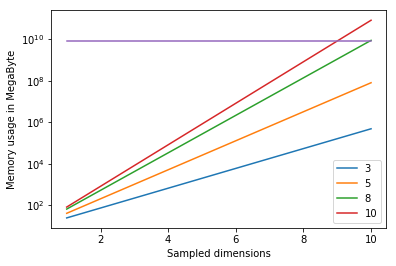

In [53]:
dims = range(1, 11)
samples = [3, 5, 8, 10]
results = []
for s in samples:
    memory_usage = np.array([s**d * 8 for d in dims])
    results.append(memory_usage)

plt.semilogy(dims, results[0],
         dims, results[1],
         dims, results[2],
         dims, results[3],
         dims, [8e9]*len(dims))
plt.xlabel("Sampled dimensions")
plt.ylabel("Memory usage in MegaByte")
plt.legend(samples)
plt.show()